In [2]:
import os
import numpy as np
import pandas as pd 
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import lightgbm as lgb
import gc
from sklearn.model_selection import KFold
from IPython.display import FileLink

# Read the data

In [3]:
data_path="../input/ubiquant-compreesed-data/"
train=pd.read_pickle('../input/trainwithcolumnsf124andf274removed/train_remove_col.pickle')
test=pd.read_pickle(os.path.join(data_path,'example_test.pickle'))
supp_train=pd.read_pickle(os.path.join(data_path,'supplemental_train.pickle'))

# Data Overview

In [4]:
print('train shape:',train.shape)
print('test shape: ',test.shape)
print('supplemental train shape:',supp_train.shape)

train shape: (3141410, 304)
test shape:  (9, 303)
supplemental train shape: (942961, 304)


In [5]:
train.head()

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0_2,0,2,-0.231040,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0_6,0,6,0.568807,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,0_7,0,7,-1.064780,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0_8,0,8,-0.531940,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624


In [6]:
test.head()

,row_id,time_id,investment_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,1220_1,1220,1,0.874944,0.457875,0.962572,0.372061,0.004509,0.971304,0.097477,...,0.514031,0.828523,0.437697,0.810764,0.693963,0.186403,0.569144,0.120386,0.419603,0.936966
1,1220_2,1220,2,0.554862,0.445478,0.714034,0.891988,0.703331,0.264478,0.600636,...,0.620919,0.301540,0.687464,0.400168,0.908198,0.272901,0.222430,0.748324,0.858802,0.362829
2,1221_0,1221,0,0.175070,0.918464,0.044379,0.505868,0.037160,0.169001,0.211365,...,0.397710,0.789382,0.238078,0.254068,0.795084,0.491928,0.376725,0.079489,0.995041,0.482283
3,1221_1,1221,1,0.355239,0.689773,0.452643,0.134863,0.794958,0.837197,0.036773,...,0.893571,0.322879,0.674692,0.114160,0.818483,0.287065,0.710537,0.550434,0.899869,0.928997
4,1221_2,1221,2,0.912778,0.462684,0.454067,0.491009,0.050547,0.250051,0.686295,...,0.031662,0.703427,0.861476,0.897927,0.659051,0.356148,0.375990,0.209798,0.175153,0.727160


In [7]:
supp_train.head()

,row_id,time_id,investment_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,...,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,target
0,0_2470,0,2470,0.857476,0.014525,0.788850,0.723694,0.110336,0.872259,0.622063,...,0.207291,0.672806,0.543164,0.140206,0.874127,0.608734,0.002161,0.777650,0.777969,0.482648
1,1_3175,1,3175,0.136743,0.365311,0.480053,0.486144,0.947280,0.828768,0.467746,...,0.719423,0.019378,0.253559,0.959608,0.044995,0.075371,0.052130,0.799216,0.392113,0.870882
2,2_1427,2,1427,0.303859,0.905065,0.653210,0.803277,0.324553,0.209632,0.801480,...,0.239102,0.654874,0.877775,0.882025,0.389150,0.995435,0.220038,0.463028,0.548430,0.135198
3,3_2842,3,2842,0.310167,0.184374,0.250553,0.408470,0.625977,0.783919,0.461546,...,0.131791,0.905971,0.647910,0.164506,0.953576,0.928850,0.617431,0.966846,0.199578,0.765027
4,4_1183,4,1183,0.751231,0.512202,0.216569,0.874850,0.786549,0.428286,0.004994,...,0.057409,0.355222,0.897738,0.475867,0.918221,0.638254,0.713265,0.827863,0.682437,0.553994


In [12]:
# check if the time_id is sorted or not
train["time_id"].is_monotonic

True

 The dataset is sorted according to time_id

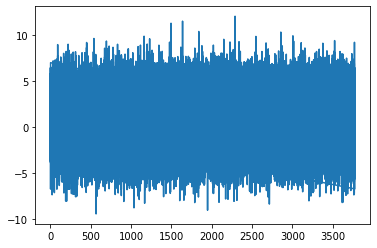

In [13]:
plt.plot(train.investment_id,train.target)

In [4]:
global_mean=train.target.mean()
print(global_mean)

-0.021091585978865623


# Encoding investment_id:Mean encoding using kfold scheme

In [5]:
traintest=pd.concat([train,test],ignore_index=True)
del train
gc.collect()

30

In [7]:
del test
gc.collect()

46

In [8]:
supp_train['investment_target_enc']=np.nan

In [ ]:
traintest['investment_target_enc']=np.nan
kf = KFold(n_splits=5, shuffle=False)
for index_train, index_valid in kf.split(traintest):
    X_tr, X_val = traintest.iloc[index_train], traintest.iloc[index_valid]
    
    # target coding of valid dataset depends on train dataset
    X_tr_group = X_tr.groupby('investment_id')['target'] 
    X_val['investment_target_enc'] = X_val['investment_id'].map(X_tr_group.mean())
    supp_train['investment_target_enc']=supp_train['investment_id'].map(X_tr_group.mean())
    # copy target encoding back to all_data
    traintest.iloc[index_valid] = X_val
    
supp_train["investment_target_enc"].fillna(global_mean,inplace=True)    
train['investment_target_enc'].fillna(global_mean, inplace=True) 

In [8]:
# final train set
traintest.to_pickle("final_traintest.pickle")
supp_train.to_pickle("final_supp_train.pickle")

In [ ]:
FileLink("./final_supp_train.pickle")

In [9]:
FileLink("./final_train.pickle")

/kaggle/working/final_train.pickle

In [ ]:
train['investment_id'].unique()

In [ ]:
train['time_id'].unique()

In [ ]:
# train ,test and supplemental train id
train_id=train.row_id
test_id=test.row_id
supp_id=supp_train.row_id

In [ ]:
# Number of NaNs for each object
train.isnull().sum(axis=1).head(15) # for each row

In [ ]:
max(train.isnull().sum(axis=1)) # max number of NaNs

No rows has a null values

In [ ]:
# similarly do for each column
train.isnull().sum(axis=0).head()

# Dataset Cleaning


Find if there any constant features ,if present then remove them as they will make dataset larger but not valuable to the training

In [ ]:
# `dropna = False` makes nunique treat NaNs as a distinct value
feats_counts = train.nunique(dropna = False)

In [ ]:
feats_counts.sort_values()[:10]

Using simple glance one can see that there are no constant features 

In [ ]:
train.time_id.head(30)

In [ ]:
# build hsitogram of the unique values
plt.figure(figsize=(14,6))
_ = plt.hist(feats_counts.astype(float)/train.shape[0], bins=100)


Get the features with lot of unique values greater than equal to 0.8 as per the above histogram

In [ ]:
mask = ((feats_counts/train.shape[0]) >=0.8)
train.loc[:, mask]

In [ ]:
# another round of features
mask2 = (feats_counts.astype(float)/train.shape[0] < 0.8) & (feats_counts.astype(float)/train.shape[0] > 0.5)
train.loc[:25, mask2]

print counts of each distinct values of some rows

In [ ]:
 # take f_8 seems to be interesting
train['f_8'].value_counts()

In [ ]:
train['f_1'].value_counts()

In [ ]:
train['f_299'].value_counts()

In [ ]:
train['f_288'].value_counts()

In [ ]:
train['f_250'].value_counts()

In [ ]:
plt.figure(figsize=(8,10))
plt.hist(train.target)
plt.title("target")
plt.show()

# plot histogram of some features between f_0 and f_299

In [ ]:
# plot 5 by 5 figures
plt.figure(figsize=(12,14))
for i in range(25):
    ax=plt.subplot(5,5,i+1)
    d=train["f_"+str(i)]
    ax.hist(d)
    ax.set_title("f_"+str(i))

# calculate correlation between features

In [ ]:
# heat map of first 100 features
plt.figure(figsize=(20,20))
sns.heatmap(train.iloc[:,4:100].corr(),vmax=1.0,center=0,fmt=".2f",square=True,
            annot=True,cbar_kws={"shrink":0.70})
plt.title("correlation map")
plt.savefig("corr.jpeg")

In [ ]:
FileLink("./corr.jpeg")

# Caculate variance of each row except row_id,time_id and investment_id

In [ ]:
for col in train.columns[4:]:
    print(col+" has variance:",train[col].var())

Remove columns which has low variance, a threshold can be maintained linke 0.05,0.1,0.2 variance less than 0.5 can be removed
Columns have variance less than 0.5 are f_124 and f_170

In [ ]:
# drop column f_124 and f_170
train.drop(columns=['f_124','f_170'])
train.to_pickle("train_remove_col.pickle")

In [ ]:
FileLink("./train_remove_col.pickle")

# Duplicate rows

In [ ]:
dups = train.iloc[:,3:].duplicated()
# report if there are any duplicates
print(dups.any())
# list all duplicate rows
print(train[dups])
